# Telco Customer Churn Prediction
Este notebook integra todos los módulos del proyecto de predicción de abandono
de clientes en un único script ejecutable en Google Colab.
Incluye la instalación de librerías, la definición de todas las funciones
y la ejecución del pipeline completo de entrenamiento y evaluación.

In [1]:
# ------------------------------------------------------------------------------
# 1. Instalación de librerías y configuración inicial
# ------------------------------------------------------------------------------
print("⚙️ Instalando librerías necesarias...")
!pip install -q pandas numpy scikit-learn xgboost matplotlib seaborn uvicorn fastapi pydantic joblib pytest imbalanced-learn lightgbm

# Conectar Google Drive para guardar/cargar archivos si es necesario
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Conexión a Google Drive exitosa.")

⚙️ Instalando librerías necesarias...
Mounted at /content/drive

✅ Conexión a Google Drive exitosa.


In [2]:
# Crear directorios para los datos y modelos
import os
data_dir = '/content/drive/MyDrive/data/raw/'
models_dir = '/content/drive/MyDrive/models/'
assets_dir = '/content/drive/MyDrive/assets/'

os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(assets_dir, exist_ok=True)

print("📁 Directorios de trabajo creados.")


📁 Directorios de trabajo creados.


In [ ]:
# Definir la ruta de destino en Google Drive
import os
drive_path = '/content/drive/MyDrive/data/raw/'
os.makedirs(drive_path, exist_ok=True)

# URL del archivo raw en tu repositorio de GitHub
github_raw_url = 'https://raw.githubusercontent.com/ravilesl/telco-churn-prediction/main/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Descargar el archivo directamente a Google Drive
!wget -O "{os.path.join(drive_path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')}" "{github_raw_url}"

print("✅ Archivo descargado y guardado en Google Drive.")

In [5]:
# ------------------------------------------------------------------------------
# 2. Módulos del Pipeline integrados
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import joblib
from typing import Optional, List, Tuple

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

# Evaluación
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_path = '/content/drive/MyDrive/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
df


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
# ==============================================================================
#                          MÓDULO: data_loader.py
# ==============================================================================
def load_raw_data(file_path: str) -> Optional[pd.DataFrame]:
    """Carga los datos crudos desde un archivo CSV."""
    try:
        df = pd.read_csv(file_path)
        print("Datos cargados exitosamente.")
        return df
    except FileNotFoundError:
        print(f"Error: El archivo no fue encontrado en {file_path}")
        return None
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None

In [8]:
# ==============================================================================
#                     MÓDULO: feature_engineering.py
# ==============================================================================
def consolidate_categories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Consolida las categorías 'No internet service' y 'No phone service' a 'No'
    en las columnas categóricas relevantes.
    """
    df_copy = df.copy()
    columns_to_consolidate = [
        'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]

    for col in columns_to_consolidate:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].replace(['No internet service', 'No phone service'], 'No')
    return df_copy

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea nuevas características para mejorar el rendimiento del modelo.
    """
    df_copy = df.copy()

    # 1. Conteo de servicios de internet y TV/Música
    internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    df_copy['InternetServiceCount'] = df_copy[internet_services].apply(lambda row: sum(1 for item in row if item == 'Yes'), axis=1)

    # 2. Característica de interacción: permanencia vs. contrato
    df_copy['tenure_contract_interaction'] = df_copy['tenure'] * df_copy['Contract'].apply(
        lambda x: 24 if x == 'Two year' else (12 if x == 'One year' else 1)
    )

    return df_copy

def preprocess_and_split(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series, ColumnTransformer]:
    """
    Procesa el dataframe y prepara los datos para el pipeline de imblearn.
    """
    # Excluir explícitamente customerID al inicio del preprocesamiento
    if 'customerID' in df.columns:
        df = df.drop(columns=['customerID'])

    # Manejar los valores nulos en TotalCharges antes de la conversión
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

    # Consolidar categorías para mejorar la codificación
    df = consolidate_categories(df)

    # Crear nuevas características
    df = create_features(df)

    df[target] = df[target].apply(lambda x: 1 if x == 'Yes' else 0)

    # Separar características y variable objetivo
    X = df.drop(columns=[target], axis=1)
    y = df[target]

    # Identificar las características numéricas y categóricas
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Crear el preprocesador para las columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    return X, y, preprocessor

In [9]:
# ==============================================================================
#                     MÓDULO: model_factory.py
# ==============================================================================
class ModelFactory:
    """Clase que crea instancias de modelos y sus parámetros para la optimización."""

    @staticmethod
    def create_model_and_params(model_name: str) -> tuple:
        """
        Crea la instancia base de un modelo y sus parámetros de búsqueda.
        """
        models_and_params = {
            'xgboost': {
                'model': xgb.XGBClassifier(random_state=42),
                'params': {
                    'model__n_estimators': [100, 200, 300],
                    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                    'model__max_depth': [3, 5, 7, 9]
                }
            },
            'logistic_regression': {
                'model': LogisticRegression(random_state=42, max_iter=1000),
                'params': {
                    'model__C': [0.01, 0.1, 1, 10, 100],
                    'model__solver': ['liblinear', 'lbfgs']
                }
            },
            'svc': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'model__C': [0.1, 1, 10, 100],
                    'model__kernel': ['rbf', 'linear']
                }
            },
            'knn': {
                'model': KNeighborsClassifier(),
                'params': {
                    'model__n_neighbors': [3, 5, 7, 9, 11, 13]
                }
            },
            'decision_tree': {
                'model': DecisionTreeClassifier(random_state=42),
                'params': {
                    'model__max_depth': [3, 5, 7, 9, None],
                    'model__min_samples_split': [2, 5, 10, 15]
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'model__n_estimators': [100, 200, 300, 400],
                    'model__max_depth': [5, 10, 15, None]
                }
            },
            'adaboost': {
                'model': AdaBoostClassifier(random_state=42),
                'params': {
                    'model__n_estimators': [50, 100, 200, 300],
                    'model__learning_rate': [0.01, 0.1, 0.5, 1.0]
                }
            },
            'gradient_boosting': {
                'model': GradientBoostingClassifier(random_state=42),
                'params': {
                    'model__n_estimators': [100, 200, 300],
                    'model__learning_rate': [0.05, 0.1, 0.2],
                    'model__max_depth': [3, 5, 7]
                }
            },
            'lightgbm': {
                'model': lgb.LGBMClassifier(random_state=42),
                'params': {
                    'model__n_estimators': [100, 200, 300],
                    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                    'model__num_leaves': [31, 62, 127]
                }
            }
        }

        if model_name in models_and_params:
            config = models_and_params[model_name]
            return config['model'], config['params']

        raise ValueError(f"Modelo '{model_name}' no soportado.")


In [10]:
# ==============================================================================
#                       MÓDULO: metrics_evaluator.py
# ==============================================================================
def evaluate_model(y_true, y_pred, model_name: str):
    """Evalúa las predicciones del modelo y genera un reporte."""
    report = classification_report(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Reporte de Evaluación para {model_name} ---")
    print(report)
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.savefig(os.path.join(assets_dir, 'confusion_matrix.png'))
    plt.close()

    return report, f1, cm

In [11]:
# ==============================================================================
#                       MÓDULO: training_pipeline.py
# ==============================================================================
# Umbral para considerar un dataset desbalanceado
HIGH_IMBALANCE_THRESHOLD = 0.10
SEMI_IMBALANCE_THRESHOLD = 0.30

def detect_class_imbalance(y):
    """
    Detecta si el dataset está desbalanceado y retorna la métrica de scoring,
    la grilla de parámetros iniciales y las técnicas de balanceo a probar.
    """
    class_counts = pd.Series(y).value_counts(normalize=True)
    minority_class_ratio = class_counts.min()
    print(f"\nProporción de la clase minoritaria: {minority_class_ratio:.2%}")

    balancing_techniques = {'no_balancing': None}
    scoring_metric = 'accuracy'

    if minority_class_ratio < HIGH_IMBALANCE_THRESHOLD:
        print("Dataset altamente desbalanceado. Usando f1-score y técnicas de sobremuestreo agresivas.")
        scoring_metric = 'f1'
        balancing_techniques.update({
            'smote': SMOTE(random_state=42),
            'adasyn': ADASYN(random_state=42)
        })
    elif HIGH_IMBALANCE_THRESHOLD <= minority_class_ratio < SEMI_IMBALANCE_THRESHOLD:
        print("Dataset semidesbalanceado. Usando f1-score y técnicas de muestreo aleatorio.")
        scoring_metric = 'f1'
        balancing_techniques.update({
            'random_oversampler': RandomOverSampler(random_state=42),
            'random_undersampler': RandomUnderSampler(random_state=42)
        })
    else:
        print("Dataset balanceado. Usando accuracy y no se aplican técnicas de balanceo.")

    return scoring_metric, balancing_techniques

def run_training_pipeline(data_path: str):
    """Orquesta el pipeline completo de entrenamiento y evaluación."""

    df = load_raw_data(data_path)
    if df is None:
        return

    # Dividimos los datos para la evaluación final
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    # Preprocesar los datos de entrenamiento para la búsqueda
    X_train, y_train, preprocessor = preprocess_and_split(df_train, 'Churn')
    print("Datos de entrenamiento preprocesados y listos.")

    scoring_metric, balancing_techniques = detect_class_imbalance(y_train)

    best_overall_score = 0
    best_overall_model = None
    best_overall_technique = ''
    best_overall_model_name = ''

    models_to_test = [
        'xgboost', 'lightgbm', 'gradient_boosting', 'random_forest',
        'adaboost', 'logistic_regression', 'decision_tree', 'knn', 'svc'
    ]

    results = {}

    for model_name in models_to_test:
        print(f"\n=======================================================")
        print(f"Probando el modelo: {model_name.upper()}")

        for tech_name, sampler in balancing_techniques.items():
            print(f"--- Probando la técnica: {tech_name} ---")

            model_base, initial_params_grid = ModelFactory.create_model_and_params(model_name)

            # Ajustar los parámetros para manejar el desbalance de clases si no se usa sobremuestreo
            if tech_name == 'no_balancing':
                class_counts = pd.Series(y_train).value_counts(normalize=True)
                scale_pos_weight_value = class_counts[0] / class_counts[1]
                # Asegúrate de que los modelos que no tienen este parámetro no se vean afectados
                if model_name in ['xgboost', 'lightgbm']:
                    initial_params_grid['model__scale_pos_weight'] = [scale_pos_weight_value, 1]
                elif model_name in ['logistic_regression', 'svc']:
                    initial_params_grid['model__class_weight'] = [None, 'balanced']


            steps = [('preprocessor', preprocessor)]
            if sampler:
                steps.append(('sampler', sampler))

            steps.append(('model', model_base))
            model_pipeline = Pipeline(steps=steps)

            grid_search = GridSearchCV(
                estimator=model_pipeline,
                param_grid=initial_params_grid,
                cv=5,
                scoring=scoring_metric,
                n_jobs=-1,
                verbose=1
            )

            grid_search.fit(X_train, y_train)

            print(f"\nMejor {scoring_metric} para {tech_name}: {grid_search.best_score_:.4f}")
            print(f"Mejores parámetros: {grid_search.best_params_}")

            current_score = grid_search.best_score_
            key = f"{model_name}_{tech_name}"
            results[key] = current_score

            if current_score > best_overall_score:
                best_overall_score = current_score
                best_overall_model = grid_search.best_estimator_
                best_overall_technique = tech_name
                best_overall_model_name = model_name

    print("\n=======================================================")
    print(f"Mejor modelo global encontrado: {best_overall_model_name.upper()} con la técnica: {best_overall_technique}")
    print(f"Mejor {scoring_metric} global: {best_overall_score:.4f}")
    print("=======================================================")

    # Gráfico comparativo de los resultados
    plt.figure(figsize=(15, 8))
    results_df = pd.Series(results).reset_index()
    results_df.columns = ['Model_Technique', 'Score']
    sns.barplot(data=results_df, x='Score', y='Model_Technique', palette='viridis')
    plt.title(f'Comparación de Modelos y Técnicas de Balanceo ({scoring_metric.upper()}-Score)')
    plt.xlabel(f'{scoring_metric.upper()}-Score')
    plt.ylabel('Modelo y Técnica')
    plt.tight_layout()
    plt.savefig(os.path.join(assets_dir, 'model_comparison.png'))
    plt.show()

    # Evaluación del mejor modelo con los datos de prueba
    X_test, y_test, _ = preprocess_and_split(df_test, 'Churn')
    y_pred = best_overall_model.predict(X_test)
    evaluate_model(y_test, y_pred, f'{best_overall_model_name.upper()} (Optimizado)')

    # Guardar el mejor modelo global
    joblib.dump(best_overall_model, os.path.join(models_dir, 'best_overall_model.pkl'))

    print("\n✅ Mejor modelo guardado en Google Drive.")
    print("\n🚀 Pipeline de entrenamiento completado. ¡Exito!")


Datos cargados exitosamente.
Datos de entrenamiento preprocesados y listos.

Proporción de la clase minoritaria: 26.55%
Dataset semidesbalanceado. Usando f1-score y técnicas de muestreo aleatorio.

Probando el modelo: XGBOOST
--- Probando la técnica: no_balancing ---
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/tmp/ipython-input-3726832067.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)



Mejor f1 para no_balancing: 0.6278
Mejores parámetros: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__scale_pos_weight': np.float64(2.766042780748663)}
--- Probando la técnica: random_oversampler ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mejor f1 para random_oversampler: 0.6269
Mejores parámetros: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 300}
--- Probando la técnica: random_undersampler ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mejor f1 para random_undersampler: 0.6303
Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Probando el modelo: LIGHTGBM
--- Probando la técnica: no_balancing ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001

/tmp/ipython-input-810305038.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Score', y='Model_Technique', palette='viridis')


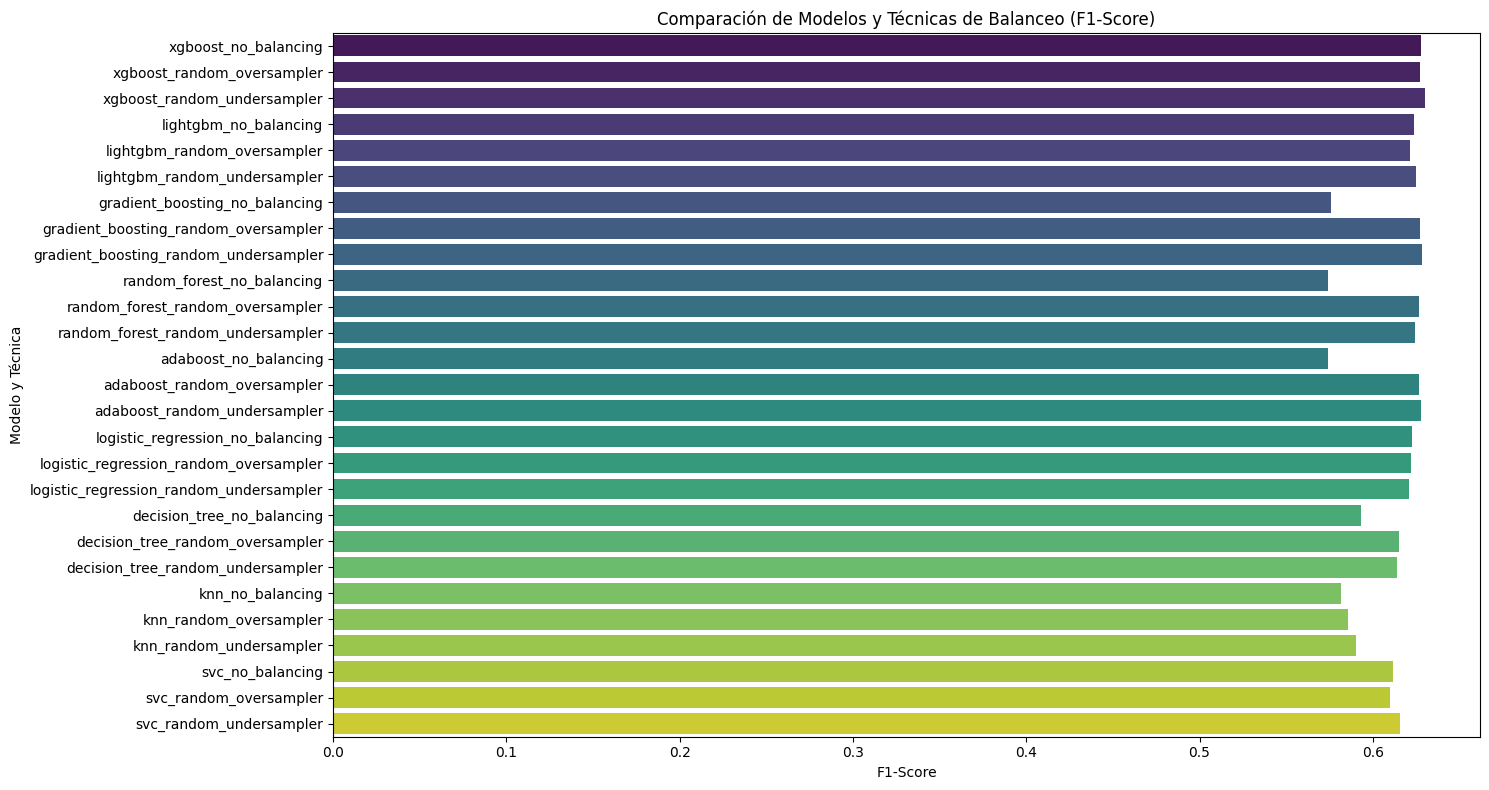

/tmp/ipython-input-3726832067.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)



--- Reporte de Evaluación para XGBOOST (Optimizado) ---
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1036
           1       0.51      0.84      0.63       373

    accuracy                           0.74      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409

F1-Score: 0.6335

✅ Mejor modelo guardado en Google Drive.

🚀 Pipeline de entrenamiento completado. ¡Exito!


In [12]:
# ------------------------------------------------------------------------------
# 3. Ejecutar el pipeline principal
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    run_training_pipeline(data_path)